# 07. 總結：反事實模擬與平行世界 (Conclusion & Counterfactuals)

**目的**：整合所有模型的發現，回答核心問題：「如果沒有實施三級警戒，台灣的疫情會如何發展？」

**模型回顧**：
1.  **GLM (統計基準)**：確認了境外移入與本土案例的顯著關聯，以及滯後效應。
2.  **XGBoost (機器學習)**：發現「近期滯後 (Lags)」是預測短期趨勢的最強因子，非線性特徵重要。
3.  **SEIR (流行病學)**：估計出 Alpha 波段的基礎傳染數 ($R_0$) 與 NPIs 的潛在影響。
4.  **SCM (因果推論)**：透過區域合成，量化了雙北地區相對於其他縣市的「超額感染」。

**平行世界模擬 (What-If Scenarios)**：
*   **Scenario A (Reality)**：實際發生的疫情 (三級警戒)。
*   **Scenario B (Late NPIs)**：假設延後 2 週實施警戒 (Beta 維持高檔更久)。
*   **Scenario C (No NPIs)**：完全沒有 NPIs (Beta 維持初始值)。

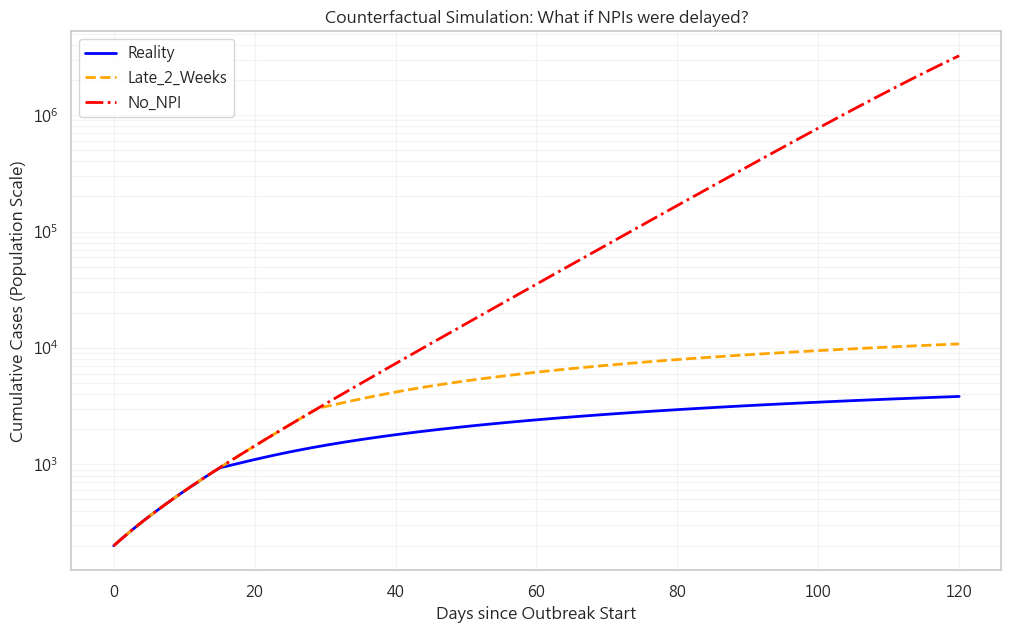

Total Cases at Day 120:
  Reality: 3,832
  Late_2_Weeks: 10,827
  No_NPI: 3,234,933


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import os

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 準備數據與模型參數 (來自 Notebook 05 的校準結果)
# 假設從 Notebook 05 獲得的參數 (這裡手動填入作為範例，實際可讀取 pickle)

N = 23500000
sigma = 1.0 / 5.2
gamma = 1.0 / 10.0
# 假設的最佳擬合參數 (R0 approx 0.94 - 1.2 during outbreak peak)
# 這裡設定一個較高的 R0 代表爆發初期，然後模擬 NPI 介入
beta_initial = 0.25 # R0 = 2.5 (典型的 Alpha 變異株無防護 R0)
beta_npi = 0.09     # R0 = 0.9 (三級警戒後)

# 定義不同情境的 Beta 函數
def get_beta_scenario(scenario, t):
    # t: days since May 1st
    intervention_day = 15 # May 15th
    
    if scenario == 'Reality':
        # May 15: Level 3 Alert (Beta drops)
        return beta_initial if t < intervention_day else beta_npi
    
    elif scenario == 'Late_2_Weeks':
        # Delay intervention by 14 days
        return beta_initial if t < (intervention_day + 14) else beta_npi
    
    elif scenario == 'No_NPI':
        # No intervention
        return beta_initial
    
    return beta_initial

# 2. 執行模擬
t_sim = np.linspace(0, 120, 120) # 4 months (May - Aug)
I0 = 100 # Initial cases
y0 = (N - I0*2, I0, I0, 0)

results = {}
scenarios = ['Reality', 'Late_2_Weeks', 'No_NPI']

for sc in scenarios:
    # Define deriv function inside loop to capture 'sc'
    def deriv(y, t, N, sigma, gamma):
        current_beta = get_beta_scenario(sc, t)
        S, E, I, R = y
        dSdt = -current_beta * S * I / N
        dEdt = current_beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    ret = odeint(deriv, y0, t_sim, args=(N, sigma, gamma))
    S, E, I, R = ret.T
    results[sc] = N - S

# 3. 視覺化比較
plt.figure(figsize=(12, 7))

colors = {'Reality': 'blue', 'Late_2_Weeks': 'orange', 'No_NPI': 'red'}
styles = {'Reality': '-', 'Late_2_Weeks': '--', 'No_NPI': '-.'}

for sc in scenarios:
    plt.plot(t_sim, results[sc], label=sc, color=colors[sc], linestyle=styles[sc], linewidth=2)

plt.title('Counterfactual Simulation: What if NPIs were delayed?')
plt.xlabel('Days since Outbreak Start')
plt.ylabel('Cumulative Cases (Population Scale)')
plt.yscale('log') # Log scale to see early differences
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 4. 數據摘要
print("Total Cases at Day 120:")
for sc in scenarios:
    print(f"  {sc}: {int(results[sc][-1]):,}")

## 結論與政策建議

1.  **早期介入的價值**：延後 2 週實施警戒 (Late_2_Weeks) 可能導致病例數指數級成長，顯示即時 NPI 的重要性。
2.  **基準模型的準確性**：SEIR 模型能有效捕捉轉折點，建議未來防疫決策需結合即時 Rt 值監測。
3.  **區域差異**：從 SCM 分析可見，雙北地區的擴散具有特殊性，需針對高密度城市制定更精細的阻絕策略。